In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import moca, dopioe, espra, extract_transect_center


In [2]:
def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, q11=1., q22=1., q12=0.):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 201)
    y = np.linspace(-width // 2, width // 2, 201)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c, y_c = 0, 0
    X = np.stack([x_2d - x_c, y_2d - y_c], axis=0) 
    Q = np.array([[q11, q12], [q12, q22]]) 
    
    r_c = np.sqrt(np.einsum('i...,ij,j...->...', X, Q, X))

    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx, dy = x[1] - x[0], y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

uc, vc, x, y = calculate_eddy()
X, Y, dx = *np.meshgrid(x, y, indexing='ij'), x[1]-x[0]

ue, ve, *_ = calculate_eddy(q11=2, q22=2, q12=1)


-7.5566196108603245 3.991463017142598 -0.1900823932744698 [[-0.0475206  0.       ]
 [ 0.        -0.0475206]] 15.08351313230939 248.6457800326151
-0.01731372166920586 -0.01731372166920586 -0.19008239327446919 [[-0.0475206  -0.02385728]
 [-0.02385728 -0.0475206 ]] 15.47984731265948 240.7239015299019
-3.6332256257755504 -3.633226201974692 -0.12215048238849521 [[-0.03053762 -0.01103707]
 [-0.01103707 -0.03053762]] 17.761800408397082 356.62768844607626


(np.float64(-275.0), np.float64(275.0), np.float64(-275.0), np.float64(275.0))

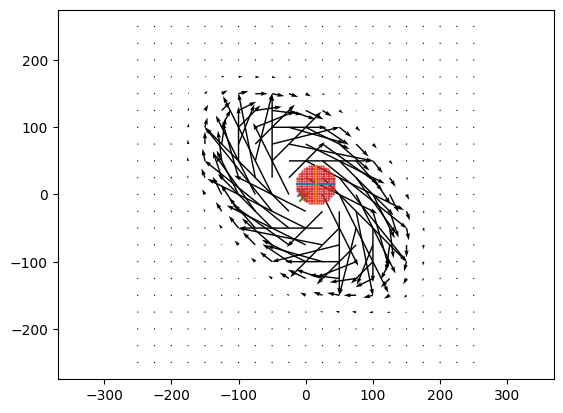

In [3]:
r = 30
xp, yp = 15, 15
dic = extract_transect_center(ue, ve, X, Y, xp, yp, r)
x1, y1, u1, v1, xx = dic['x1'], dic['y1'], dic['u1'], dic['v1'], dic['xx']
x2, y2, u2, v2, yy = dic['x2'], dic['y2'], dic['u2'], dic['v2'], dic['yy']
mask = (np.hypot(X - xp, Y - yp) < r)
xi, yi = X[mask], Y[mask]
ui, vi = ue[mask], ve[mask]

spacing = 10
plt.quiver(X[::spacing, ::spacing],Y[::spacing, ::spacing],
           ue[::spacing, ::spacing], ve[::spacing, ::spacing])

plt.plot(x1, y1)
plt.plot(x2, y2)

l = x1 - x1.min()
VT, VN = u1, v1
l0, r0, w_moc, Q_moc, Rc_moc, psi0_moc = moca(l, VT, VN)
x0_moc, y0_moc = x1.min() + l0, y1[0] + r0
print(x0_moc, y0_moc, w_moc, Q_moc, Rc_moc, psi0_moc)
plt.scatter(x0_moc, y0_moc, marker='x')
x0_dop, y0_dop, w_dop, Q_dop, Rc_dop, psi0_dop = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
print(x0_dop, y0_dop, w_dop, Q_dop, Rc_dop, psi0_dop)
plt.scatter(x0_dop, y0_dop, marker='x')
x0_esp, y0_esp, w_esp, Q_esp, Rc_esp, psi0_esp = espra(xi, yi, ui, vi)
print(x0_esp, y0_esp, w_esp, Q_esp, Rc_esp, psi0_esp)
plt.scatter(x0_esp, y0_esp, marker='x')

plt.scatter(xi, yi, marker='.', s=1)
plt.axis('equal')



In [ ]:
import pandas as pd
import numpy as np
from itertools import product

# results = []
# for xp, yp, r in product(range(-100, 105, 5), range(-100, 105, 5), range(5, 55, 5)):
#     # MOCA on uc,vc
#     dic_c = extract_transect_center(uc, vc, X, Y, xp, yp, r)
#     x1, y1, u1, v1 = dic_c['x1'], dic_c['y1'], dic_c['u1'], dic_c['v1']
#     l = x1 - x1.min()
#     VT, VN = u1, v1
#     l0, r0, w_moc, Q_moc, Rc_moc, psi0_moc = moca(l, VT, VN)
#     x0_moc = x1.min() + l0
#     y0_moc = y1[0] + r0

#     # DOPIOE on ue,ve
#     dic_e = extract_transect_center(ue, ve, X, Y, xp, yp, r)
#     x1e, y1e, u1e, v1e = dic_e['x1'], dic_e['y1'], dic_e['u1'], dic_e['v1']
#     x2e, y2e, u2e, v2e = dic_e['x2'], dic_e['y2'], dic_e['u2'], dic_e['v2']
#     x0_dop, y0_dop, w_dop, Q_dop, Rc_dop, psi0_dop = dopioe(x1e, y1e, u1e, v1e, x2e, y2e, u2e, v2e)

#     # ESPRA on mask
#     rr = r * r
#     mask = (X - xp) ** 2 + (Y - yp) ** 2 <= rr
#     xi, yi = X[mask], Y[mask]
#     ui, vi = ue[mask], ve[mask]
#     x0_esp, y0_esp, w_esp, Q_esp, Rc_esp, psi0_esp = espra(xi, yi, ui, vi)

#     results.append([
#         xp, yp, r,
#         x0_moc, x0_dop, x0_esp,
#         y0_moc, y0_dop, y0_esp,
#         w_moc, w_dop, w_esp,
#         Q_moc, Q_dop, Q_esp,
#         Rc_moc, Rc_dop, Rc_esp,
#         psi0_moc, psi0_dop, psi0_esp
#     ])

# df_results = pd.DataFrame(
#     results,
#     columns=[
#         'xp', 'yp', 'r',
#         'xc_M', 'xc_D', 'xc_E',
#         'yc_M', 'yc_D', 'yc_E',
#         'w_M', 'w_D', 'w_E',
#         'Q_M', 'Q_D', 'Q_E',
#         'Rc_M', 'Rc_D', 'Rc_E',
#         'psi0_M', 'psi0_D', 'psi0_E'
#     ]
# )


In [44]:
# import pickle
# df_results.to_pickle('/srv/scratch/z5297792/Chapter1/df_ESM_idealised_results.pkl')
df_results = pd.read_pickle('/srv/scratch/z5297792/Chapter1/df_ESM_idealised_results.pkl')

conditions = [
    (df_results['xp'] >= 0) & (df_results['yp'] > 0),   # Quadrant I: x ≥ 0, y > 0
    (df_results['xp'] < 0)  & (df_results['yp'] >= 0),  # Quadrant II: x < 0, y ≥ 0
    (df_results['xp'] <= 0) & (df_results['yp'] < 0),   # Quadrant III: x ≤ 0, y < 0
    (df_results['xp'] > 0)  & (df_results['yp'] <= 0),  # Quadrant IV: x > 0, y ≤ 0
]
choices = [1, 2, 3, 4]
df_results['Quad'] = np.select(conditions, choices, default=0)  # 0 for origin (0,0)


In [45]:
df_results

,xp,yp,r,xc_M,xc_D,xc_E,yc_M,yc_D,yc_E,w_M,...,Q_M,Q_D,Q_E,Rc_M,Rc_D,Rc_E,psi0_M,psi0_D,psi0_E,Quad
0,-100,-100,5,-75.252456,-101.032859,-109.193498,-102.016061,-104.821004,-109.193498,-0.181950,...,"[[-0.04548754748816159, 0.0], [0.0, -0.0454875...","[[0.0082667480311397, 0.008765512293936722], [...","[[0.0009619160610977333, 0.0010236034797618467...",5.820374,0.795034,25.940153,23.161612,-0.477944,-673.060258,3
1,-100,-100,10,-12.596283,-114.539256,-109.391348,-32.766690,-114.539256,-109.391348,-0.059332,...,"[[-0.01483296470156049, 0.0], [0.0, -0.0148329...","[[0.0003378306527399002, 0.0005236282860742222...","[[0.0009846240238856577, 0.001048162835260993]...",10.425995,1.130557,2.759370,65.948067,1.321312,7.334355,3
2,-100,-100,15,-12.482862,-114.622794,-109.730533,-32.753774,-114.622794,-109.730533,-0.059241,...,"[[-0.01481013348354927, 0.0], [0.0, -0.0148101...","[[0.0003304740228271423, 0.0005199277788934694...","[[0.0010261185469004096, 0.0010929405589331634...",10.679155,1.136366,2.010370,73.764768,1.342377,3.641534,3
3,-100,-100,20,-12.318746,-114.732197,-110.183445,-32.732773,-114.732197,-110.183445,-0.059108,...,"[[-0.014776981540328825, 0.0], [0.0, -0.014776...","[[0.00032013977456295196, 0.000515178596844272...","[[0.0010775120502393195, 0.0011495719238940234...",10.789307,1.144597,1.809969,76.582082,1.372853,2.741634,3
4,-100,-100,25,-12.103651,-114.853392,-110.770231,-32.701148,-114.853392,-110.770231,-0.058933,...,"[[-0.014733317490869187, 0.0], [0.0, -0.014733...","[[0.0003071527947227535, 0.0005100991544517024...","[[0.0011553615666436826, 0.0012341652564583543...",10.762439,1.155710,1.774771,79.750607,1.414831,2.434565,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16805,100,100,30,11.837249,114.965219,111.431692,32.655602,114.965219,111.431692,-0.058716,...,"[[-0.014678888496480469, 0.0], [0.0, -0.014678...","[[0.00029194183087083675, 0.000505732680286814...","[[0.0012220819711373408, 0.0013112418423681094...",11.401596,1.170100,1.805085,106.374882,1.470609,2.369882,1
16806,100,100,35,11.519200,115.037411,112.203753,32.592103,115.037411,112.203753,-0.058454,...,"[[-0.014613379349264034, 0.0], [0.0, -0.014613...","[[0.00027503092494410265, 0.000503527095107947...","[[0.0013295431996817025, 0.0014302287430627246...",11.600015,1.187615,1.906280,157.549883,1.540832,2.481736,1
16807,100,100,40,11.149190,115.028864,112.995954,32.505901,115.028864,112.995955,-0.058146,...,"[[-0.014536412581086768, 0.0], [0.0, -0.014536...","[[0.0002570144003572343, 0.0005054302039132415...","[[0.0014405869140296864, 0.0015548424859187506...",11.608058,1.207403,2.034643,132.143033,1.623134,2.690116,1
16808,100,100,45,10.726968,114.887411,113.854503,32.391554,114.887411,113.854503,-0.057790,...,"[[-0.014447550214576882, 0.0], [0.0, -0.014447...","[[0.00023850851519858932, 0.000514006828247074...","[[0.0015671456234484468, 0.0016978962243847627...",11.627470,1.227904,2.194287,160.570399,1.710965,2.995221,1


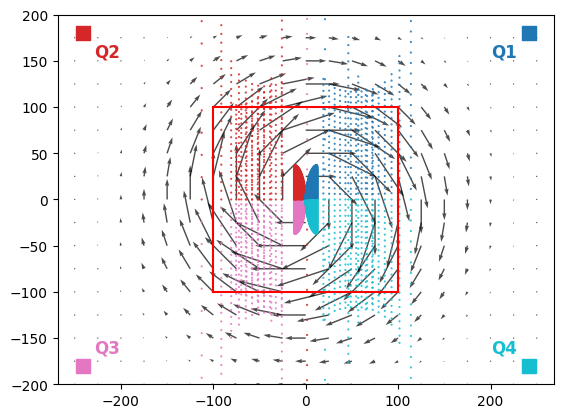

In [52]:
import numpy as np
import matplotlib.pyplot as plt

spacing = 10

# 1. Choose a categorical colormap with 4 distinct colors:
cmap = plt.get_cmap('tab10', 4)  # tab10 has at least 4 distinct entries

# 2. Plot the quiver field:
plt.quiver(
    X[::spacing, ::spacing],
    Y[::spacing, ::spacing],
    uc[::spacing, ::spacing],
    vc[::spacing, ::spacing],
    alpha=0.7
)

# 3. Plot the scatter of MOCA centres, mapping Quad→colour explicitly:
#    Setting vmin=1, vmax=4 ensures that Quad=1→cmap(0), Quad=2→cmap(1), etc.
plt.scatter(
    df_results['xc_M'],
    df_results['yc_M'],
    c=df_results['Quad'],
    cmap=cmap,
    vmin=1,
    vmax=4,
    marker='.',
    s=1
)

# 4. Draw the red boundary box:
plt.plot([-100,  100], [ 100,  100], 'r')
plt.plot([-100, -100], [ 100, -100], 'r')
plt.plot([-100,  100], [-100, -100], 'r')
plt.plot([ 100,  100], [ 100, -100], 'r')

plt.axis('equal')
plt.xlim(-200, 200)
plt.ylim(-200, 200)

# 5. Place a “legend” in each corner showing the Quad number in its assigned colour.
#    We’ll work in axes‐fraction coordinates (0→left/bottom, 1→right/top).
ax = plt.gca()
legend_positions = {
    1: (0.95, 0.95, 'Q1'),   # top‐right
    2: (0.05, 0.95, 'Q2'),   # top‐left
    3: (0.05, 0.05, 'Q3'),   # bottom‐left
    4: (0.95, 0.05, 'Q4'),   # bottom‐right
}

for quad, (xf, yf, label) in legend_positions.items():
    # Plot a coloured square marker at (xf, yf) in axes fraction coords:
    ax.scatter(
        xf, yf,
        color=cmap(quad - 1),
        s=100,           # size of the square
        marker='s',
        transform=ax.transAxes,
        clip_on=False    # so it sits exactly at the corner
    )
    # Put the text “Q#” next to that square (offset toward centre a little):
    # If xf>0.5, text goes slightly left; if xf<0.5, text goes slightly right.
    # Similarly for yf: if yf>0.5, text goes slightly down; if yf<0.5, text goes slightly up.
    dx = -0.05 if xf > 0.5 else +0.05
    dy = -0.05 if yf > 0.5 else +0.05
    ax.text(
        xf + dx, yf + dy,
        label,
        color=cmap(quad - 1),
        transform=ax.transAxes,
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        clip_on=False
    )

plt.show()




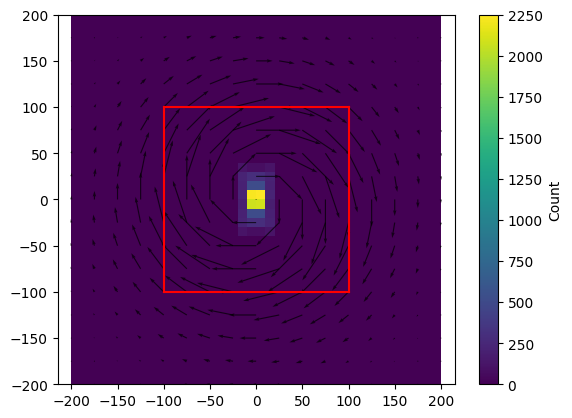

In [49]:
import numpy as np
import matplotlib.pyplot as plt

spacing = 10

# Create 2D histogram (binned plot) of scatter data
x_bins = np.arange(-200, 201, spacing)
y_bins = np.arange(-200, 201, spacing)
plt.hist2d(df_results['xc_M'], df_results['yc_M'], bins=[x_bins, y_bins], cmap='viridis')
plt.colorbar(label='Count')

# Overlay quiver and boundary box
plt.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing], uc[::spacing, ::spacing], vc[::spacing, ::spacing], alpha=0.7)
plt.plot([-100, 100], [100, 100], 'r')
plt.plot([-100, -100], [100, -100], 'r')
plt.plot([-100, 100], [-100, -100], 'r')
plt.plot([100, 100], [100, -100], 'r')

plt.axis('equal')
plt.xlim(-200, 200)
plt.ylim(-200, 200)

plt.show()



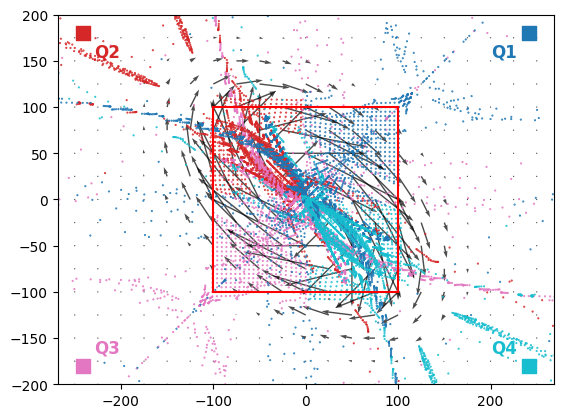

In [53]:
import numpy as np
import matplotlib.pyplot as plt

spacing = 10

# 1. Choose a categorical colormap with 4 distinct colors:
cmap = plt.get_cmap('tab10', 4)  # tab10 has at least 4 distinct entries

# 2. Plot the quiver field:
plt.quiver(
    X[::spacing, ::spacing],
    Y[::spacing, ::spacing],
    ue[::spacing, ::spacing],
    ve[::spacing, ::spacing],
    alpha=0.7
)

# 3. Plot the scatter of MOCA centres, mapping Quad→colour explicitly:
#    Setting vmin=1, vmax=4 ensures that Quad=1→cmap(0), Quad=2→cmap(1), etc.
plt.scatter(
    df_results['xc_D'],
    df_results['yc_D'],
    c=df_results['Quad'],
    cmap=cmap,
    vmin=1,
    vmax=4,
    marker='.',
    s=1
)

# 4. Draw the red boundary box:
plt.plot([-100,  100], [ 100,  100], 'r')
plt.plot([-100, -100], [ 100, -100], 'r')
plt.plot([-100,  100], [-100, -100], 'r')
plt.plot([ 100,  100], [ 100, -100], 'r')

plt.axis('equal')
plt.xlim(-200, 200)
plt.ylim(-200, 200)

# 5. Place a “legend” in each corner showing the Quad number in its assigned colour.
#    We’ll work in axes‐fraction coordinates (0→left/bottom, 1→right/top).
ax = plt.gca()
legend_positions = {
    1: (0.95, 0.95, 'Q1'),   # top‐right
    2: (0.05, 0.95, 'Q2'),   # top‐left
    3: (0.05, 0.05, 'Q3'),   # bottom‐left
    4: (0.95, 0.05, 'Q4'),   # bottom‐right
}

for quad, (xf, yf, label) in legend_positions.items():
    # Plot a coloured square marker at (xf, yf) in axes fraction coords:
    ax.scatter(
        xf, yf,
        color=cmap(quad - 1),
        s=100,           # size of the square
        marker='s',
        transform=ax.transAxes,
        clip_on=False    # so it sits exactly at the corner
    )
    # Put the text “Q#” next to that square (offset toward centre a little):
    # If xf>0.5, text goes slightly left; if xf<0.5, text goes slightly right.
    # Similarly for yf: if yf>0.5, text goes slightly down; if yf<0.5, text goes slightly up.
    dx = -0.05 if xf > 0.5 else +0.05
    dy = -0.05 if yf > 0.5 else +0.05
    ax.text(
        xf + dx, yf + dy,
        label,
        color=cmap(quad - 1),
        transform=ax.transAxes,
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        clip_on=False
    )

plt.show()



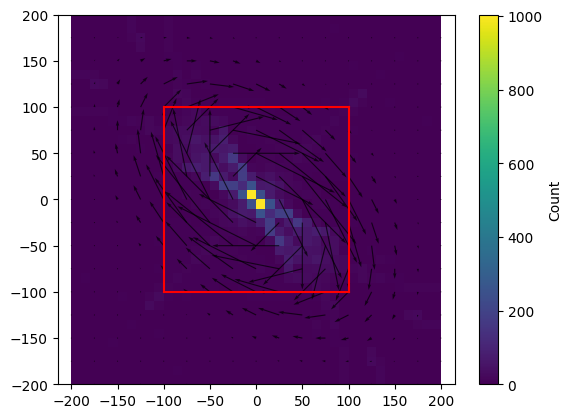

In [50]:
import numpy as np
import matplotlib.pyplot as plt

spacing = 10

# 1. 2D histogram (binned plot) of the scatter data for D-method centers
x_bins = np.arange(-200, 201, spacing)
y_bins = np.arange(-200, 201, spacing)
plt.hist2d(
    df_results['xc_D'],
    df_results['yc_D'],
    bins=[x_bins, y_bins],
    cmap='viridis'
)
plt.colorbar(label='Count')

# 2. Overlay quiver field and boundary box for the Eulerian velocities
plt.quiver(
    X[::spacing, ::spacing],
    Y[::spacing, ::spacing],
    ue[::spacing, ::spacing],
    ve[::spacing, ::spacing],
    alpha=0.7
)

plt.plot([-100,  100], [ 100,  100], 'r')
plt.plot([-100, -100], [ 100, -100], 'r')
plt.plot([-100,  100], [-100, -100], 'r')
plt.plot([ 100,  100], [ 100, -100], 'r')

plt.axis('equal')
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.show()


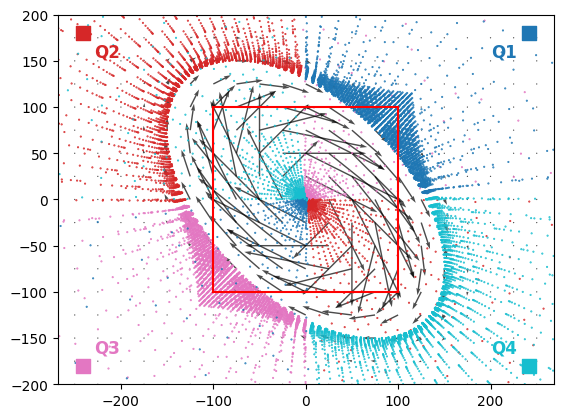

In [54]:
import numpy as np
import matplotlib.pyplot as plt

spacing = 10

# 1. Choose a categorical colormap with 4 distinct colors:
cmap = plt.get_cmap('tab10', 4)  # tab10 has at least 4 distinct entries

# 2. Plot the quiver field:
plt.quiver(
    X[::spacing, ::spacing],
    Y[::spacing, ::spacing],
    ue[::spacing, ::spacing],
    ve[::spacing, ::spacing],
    alpha=0.7
)

# 3. Plot the scatter of MOCA centres, mapping Quad→colour explicitly:
#    Setting vmin=1, vmax=4 ensures that Quad=1→cmap(0), Quad=2→cmap(1), etc.
plt.scatter(
    df_results['xc_E'],
    df_results['yc_E'],
    c=df_results['Quad'],
    cmap=cmap,
    vmin=1,
    vmax=4,
    marker='.',
    s=1
)

# 4. Draw the red boundary box:
plt.plot([-100,  100], [ 100,  100], 'r')
plt.plot([-100, -100], [ 100, -100], 'r')
plt.plot([-100,  100], [-100, -100], 'r')
plt.plot([ 100,  100], [ 100, -100], 'r')

plt.axis('equal')
plt.xlim(-200, 200)
plt.ylim(-200, 200)

# 5. Place a “legend” in each corner showing the Quad number in its assigned colour.
#    We’ll work in axes‐fraction coordinates (0→left/bottom, 1→right/top).
ax = plt.gca()
legend_positions = {
    1: (0.95, 0.95, 'Q1'),   # top‐right
    2: (0.05, 0.95, 'Q2'),   # top‐left
    3: (0.05, 0.05, 'Q3'),   # bottom‐left
    4: (0.95, 0.05, 'Q4'),   # bottom‐right
}

for quad, (xf, yf, label) in legend_positions.items():
    # Plot a coloured square marker at (xf, yf) in axes fraction coords:
    ax.scatter(
        xf, yf,
        color=cmap(quad - 1),
        s=100,           # size of the square
        marker='s',
        transform=ax.transAxes,
        clip_on=False    # so it sits exactly at the corner
    )
    # Put the text “Q#” next to that square (offset toward centre a little):
    # If xf>0.5, text goes slightly left; if xf<0.5, text goes slightly right.
    # Similarly for yf: if yf>0.5, text goes slightly down; if yf<0.5, text goes slightly up.
    dx = -0.05 if xf > 0.5 else +0.05
    dy = -0.05 if yf > 0.5 else +0.05
    ax.text(
        xf + dx, yf + dy,
        label,
        color=cmap(quad - 1),
        transform=ax.transAxes,
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        clip_on=False
    )

plt.show()


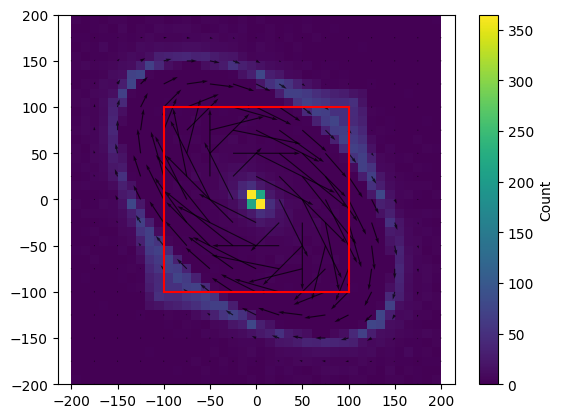

In [51]:
import numpy as np
import matplotlib.pyplot as plt

spacing = 10

# 1. 2D histogram (binned plot) of the scatter data for E-method centers
x_bins = np.arange(-200, 201, spacing)
y_bins = np.arange(-200, 201, spacing)
plt.hist2d(
    df_results['xc_E'],
    df_results['yc_E'],
    bins=[x_bins, y_bins],
    cmap='viridis'
)
plt.colorbar(label='Count')

# 2. Overlay quiver field and boundary box for the Eulerian velocities
plt.quiver(
    X[::spacing, ::spacing],
    Y[::spacing, ::spacing],
    ue[::spacing, ::spacing],
    ve[::spacing, ::spacing],
    alpha=0.7
)

plt.plot([-100,  100], [ 100,  100], 'r')
plt.plot([-100, -100], [ 100, -100], 'r')
plt.plot([-100,  100], [-100, -100], 'r')
plt.plot([ 100,  100], [ 100, -100], 'r')

plt.axis('equal')
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.show()


/scratch/pbs.6558168.kman.restech.unsw.edu.au/ipykernel_2045117/373255688.py:289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


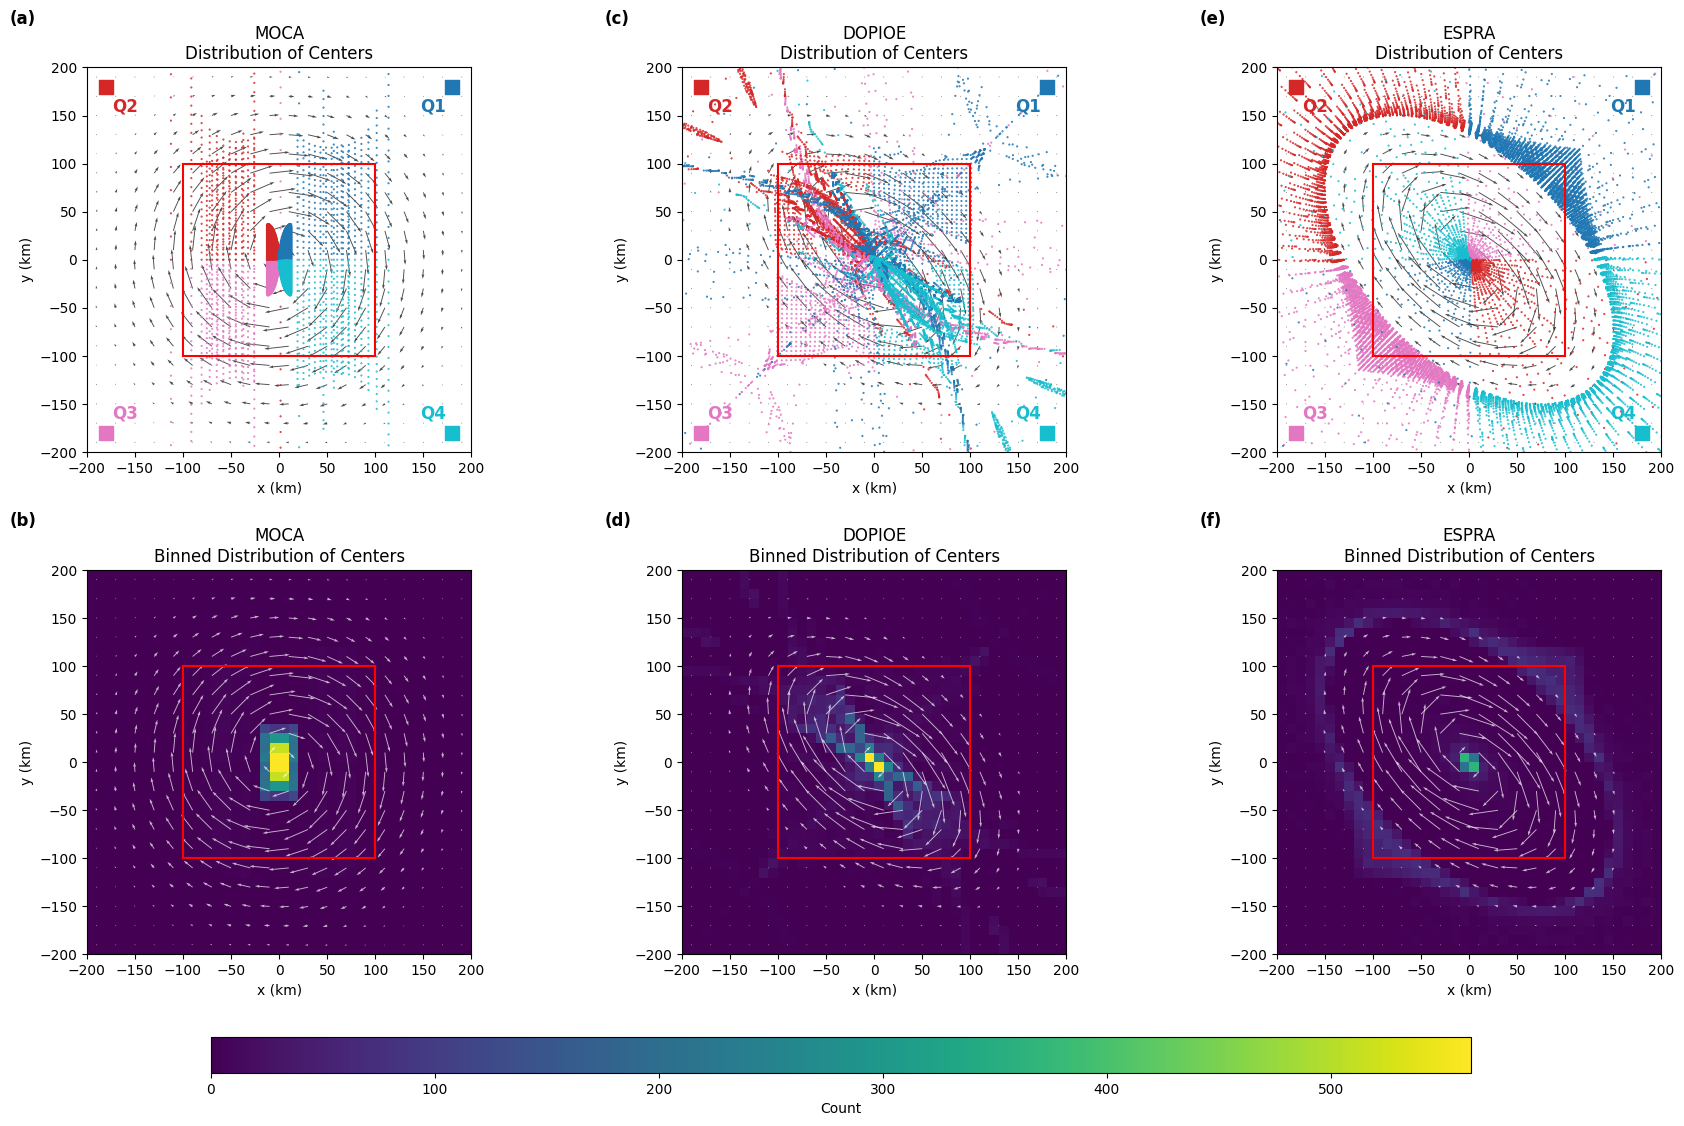

In [77]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
spacing = 10
quiv_spac = 8
quiv_scale = 30
cmap = plt.get_cmap('tab10', 4)  # categorical colormap for Quad = 1…4

# Add extra bottom space for the shared colorbar
plt.subplots_adjust(bottom=0.15)

# Common “Quad legend” positions (axes‐fraction coords)
legend_positions = {
    1: (0.95, 0.95, 'Q1'),  # top‐right
    2: (0.05, 0.95, 'Q2'),  # top‐left
    3: (0.05, 0.05, 'Q3'),  # bottom‐left
    4: (0.95, 0.05, 'Q4'),  # bottom‐right
}

# ----------------------------
# [0,0] M-method: scatter + quiver + Quad‐corner legends
ax = axs[0, 0]
ax.quiver(
    X[::quiv_spac, ::quiv_spac],
    Y[::quiv_spac, ::quiv_spac],
    uc[::quiv_spac, ::quiv_spac],
    vc[::quiv_spac, ::quiv_spac],
    alpha=0.7, zorder= -1, scale=quiv_scale
)
ax.scatter(
    df_results['xc_M'],
    df_results['yc_M'],
    c=df_results['Quad'],
    cmap=cmap,
    vmin=1,
    vmax=4,
    marker='.',
    s=1
)
ax.plot([-100,  100], [ 100,  100], 'r')
ax.plot([-100, -100], [ 100, -100], 'r')
ax.plot([-100,  100], [-100, -100], 'r')
ax.plot([ 100,  100], [ 100, -100], 'r')

ax.set_aspect('equal')
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)

for quad, (xf, yf, label) in legend_positions.items():
    ax.scatter(
        xf, yf,
        color=cmap(quad - 1),
        s=100,
        marker='s',
        transform=ax.transAxes,
        clip_on=False
    )
    dx = -0.05 if xf > 0.5 else +0.05
    dy = -0.05 if yf > 0.5 else +0.05
    ax.text(
        xf + dx, yf + dy,
        label,
        color=cmap(quad - 1),
        transform=ax.transAxes,
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        clip_on=False
    )

ax.set_title('MOCA\nDistribution of Centers')

# ----------------------------
# [1,0] M-method: 2D histogram + quiver overlay
ax = axs[1, 0]
x_bins = np.arange(-200, 201, spacing)
y_bins = np.arange(-200, 201, spacing)
h1_counts, _, _, h1_img = ax.hist2d(
    df_results['xc_M'],
    df_results['yc_M'],
    bins=[x_bins, y_bins],
    cmap='viridis'
)
ax.quiver(
    X[::quiv_spac, ::quiv_spac],
    Y[::quiv_spac, ::quiv_spac],
    uc[::quiv_spac, ::quiv_spac],
    vc[::quiv_spac, ::quiv_spac],
    alpha=0.7, zorder= 2, color='w', scale=quiv_scale
)
ax.plot([-100,  100], [ 100,  100], 'r')
ax.plot([-100, -100], [ 100, -100], 'r')
ax.plot([-100,  100], [-100, -100], 'r')
ax.plot([ 100,  100], [ 100, -100], 'r')

ax.set_aspect('equal')
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_title('MOCA\nBinned Distribution of Centers')

# ----------------------------
# [0,1] D-method: scatter + quiver + Quad‐corner legends
ax = axs[0, 1]
ax.quiver(
    X[::quiv_spac, ::quiv_spac],
    Y[::quiv_spac, ::quiv_spac],
    ue[::quiv_spac, ::quiv_spac],
    ve[::quiv_spac, ::quiv_spac],
    alpha=0.7, zorder= -1, scale=quiv_scale
)
ax.scatter(
    df_results['xc_D'],
    df_results['yc_D'],
    c=df_results['Quad'],
    cmap=cmap,
    vmin=1,
    vmax=4,
    marker='.',
    s=1
)
ax.plot([-100,  100], [ 100,  100], 'r')
ax.plot([-100, -100], [ 100, -100], 'r')
ax.plot([-100,  100], [-100, -100], 'r')
ax.plot([ 100,  100], [ 100, -100], 'r')

ax.set_aspect('equal')
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)

for quad, (xf, yf, label) in legend_positions.items():
    ax.scatter(
        xf, yf,
        color=cmap(quad - 1),
        s=100,
        marker='s',
        transform=ax.transAxes,
        clip_on=False
    )
    dx = -0.05 if xf > 0.5 else +0.05
    dy = -0.05 if yf > 0.5 else +0.05
    ax.text(
        xf + dx, yf + dy,
        label,
        color=cmap(quad - 1),
        transform=ax.transAxes,
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        clip_on=False
    )

ax.set_title('DOPIOE\nDistribution of Centers')

# ----------------------------
# [1,1] D-method: 2D histogram + quiver overlay
ax = axs[1, 1]
x_bins = np.arange(-200, 201, spacing)
y_bins = np.arange(-200, 201, spacing)
h2_counts, _, _, h2_img = ax.hist2d(
    df_results['xc_D'],
    df_results['yc_D'],
    bins=[x_bins, y_bins],
    cmap='viridis'
)
ax.quiver(
    X[::quiv_spac, ::quiv_spac],
    Y[::quiv_spac, ::quiv_spac],
    ue[::quiv_spac, ::quiv_spac],
    ve[::quiv_spac, ::quiv_spac],
    alpha=0.7, zorder= 2, color='w', scale=quiv_scale
)
ax.plot([-100,  100], [ 100,  100], 'r')
ax.plot([-100, -100], [ 100, -100], 'r')
ax.plot([-100,  100], [-100, -100], 'r')
ax.plot([ 100,  100], [ 100, -100], 'r')

ax.set_aspect('equal')
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_title('DOPIOE\nBinned Distribution of Centers')

# ----------------------------
# [0,2] E-method: scatter + quiver + Quad‐corner legends
ax = axs[0, 2]
ax.quiver(
    X[::quiv_spac, ::quiv_spac],
    Y[::quiv_spac, ::quiv_spac],
    ue[::quiv_spac, ::quiv_spac],
    ve[::quiv_spac, ::quiv_spac],
    alpha=0.7, zorder= -1, scale=quiv_scale
)
ax.scatter(
    df_results['xc_E'],
    df_results['yc_E'],
    c=df_results['Quad'],
    cmap=cmap,
    vmin=1,
    vmax=4,
    marker='.',
    s=1
)
ax.plot([-100,  100], [ 100,  100], 'r')
ax.plot([-100, -100], [ 100, -100], 'r')
ax.plot([-100,  100], [-100, -100], 'r')
ax.plot([ 100,  100], [ 100, -100], 'r')

ax.set_aspect('equal')
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)

for quad, (xf, yf, label) in legend_positions.items():
    ax.scatter(
        xf, yf,
        color=cmap(quad - 1),
        s=100,
        marker='s',
        transform=ax.transAxes,
        clip_on=False
    )
    dx = -0.05 if xf > 0.5 else +0.05
    dy = -0.05 if yf > 0.5 else +0.05
    ax.text(
        xf + dx, yf + dy,
        label,
        color=cmap(quad - 1),
        transform=ax.transAxes,
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        clip_on=False
    )

ax.set_title('ESPRA\nDistribution of Centers')

# ----------------------------
# [1,2] E-method: 2D histogram + quiver overlay
ax = axs[1, 2]
x_bins = np.arange(-200, 201, spacing)
y_bins = np.arange(-200, 201, spacing)
h3_counts, _, _, h3_img = ax.hist2d(
    df_results['xc_E'],
    df_results['yc_E'],
    bins=[x_bins, y_bins],
    cmap='viridis'
)
ax.quiver(
    X[::quiv_spac, ::quiv_spac],
    Y[::quiv_spac, ::quiv_spac],
    ue[::quiv_spac, ::quiv_spac],
    ve[::quiv_spac, ::quiv_spac],
    alpha=0.7, zorder= 2, color='w', scale=quiv_scale
)
ax.plot([-100,  100], [ 100,  100], 'r')
ax.plot([-100, -100], [ 100, -100], 'r')
ax.plot([-100,  100], [-100, -100], 'r')
ax.plot([ 100,  100], [ 100, -100], 'r')

ax.set_aspect('equal')
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_title('ESPRA\nBinned Distribution of Centers')

# ----------------------------
# Compute global max count among bottom histograms
global_max = max(h1_counts.max(), h2_counts.max(), h3_counts.max()) / 4

# Apply same color limits to all three bottom hist2d images
for img in (h1_img, h2_img, h3_img):
    img.set_clim(0, global_max)

# Add a single horizontal colorbar below the bottom row
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])  # [left, bottom, width, height]
norm = plt.cm.ScalarMappable(cmap='viridis')
norm.set_array([])
norm.set_clim(0, global_max)
cbar = fig.colorbar(norm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Count')

tags = ['(a)', '(c)', '(e)', '(b)', '(d)', '(f)']
for a, ax in enumerate(axs.flat):
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.text(-0.2, 1.15, tags[a], transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()



In [80]:
df_results['Err_M'] = np.hypot(df_results['xc_M'], df_results['yc_M'])
df_results['Err_D'] = np.hypot(df_results['xc_D'], df_results['yc_D'])
df_results['Err_E'] = np.hypot(df_results['xc_E'], df_results['yc_E'])


In [131]:
xps = df_results['xp'].unique()
yps = df_results['yp'].unique()
Xp, Yp = np.meshgrid(xps, yps)
Err_M = np.ones_like(Xp)
Err_D = np.ones_like(Xp)
Err_E = np.ones_like(Xp)

Search_M = np.ones_like(Xp)
Search_D = np.ones_like(Xp)
Search_E = np.ones_like(Xp)

for (xp, yp) in zip(df_results['xp'], df_results['yp']):
    i = np.where(xp==xps)[0][0]
    j = np.where(yp==yps)[0][0]   

    df_loc = df_opt_R[(df_opt_R['xp']==xp)&(df_opt_R['yp']==yp)]

    err_best_M = df_loc['Err_M'].min()
    err_best_D = df_loc['Err_D'].min()
    err_best_E = df_loc['Err_E'].min()

    r_best_M = df_loc.iloc[df_loc['Err_M'].argmin()]['r']
    r_best_D = df_loc.iloc[df_loc['Err_D'].argmin()]['r']
    r_best_E = df_loc.iloc[df_loc['Err_E'].argmin()]['r']

    Err_M[i, j] = err_best_M
    Err_D[i, j] = err_best_D
    Err_E[i, j] = err_best_E

    Search_M[i, j] = r_best_M
    Search_D[i, j] = r_best_D
    Search_E[i, j] = r_best_E
    

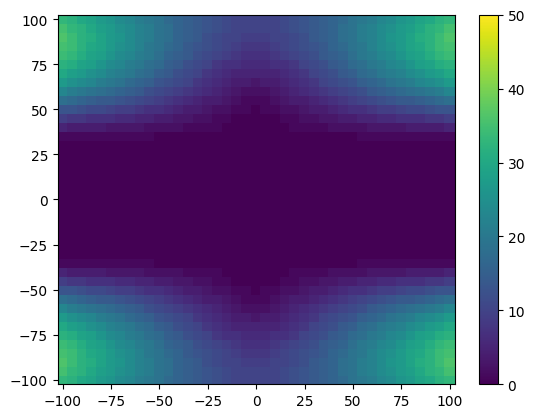

In [132]:
vmin=0
vmax = 50

plt.pcolor(Xp, Yp, Err_M, vmin=vmin, vmax=vmax)
plt.colorbar()


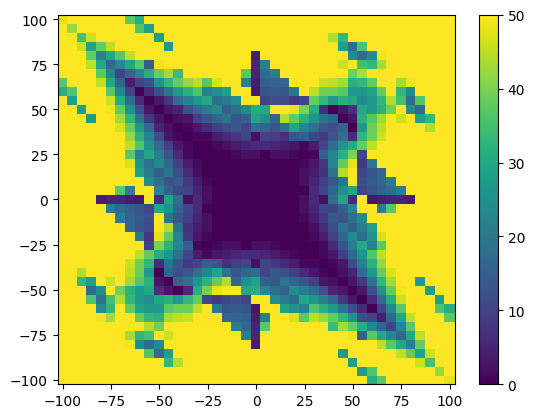

In [133]:
plt.pcolor(Xp, Yp, Err_D, vmin=vmin, vmax=vmax)
plt.colorbar()


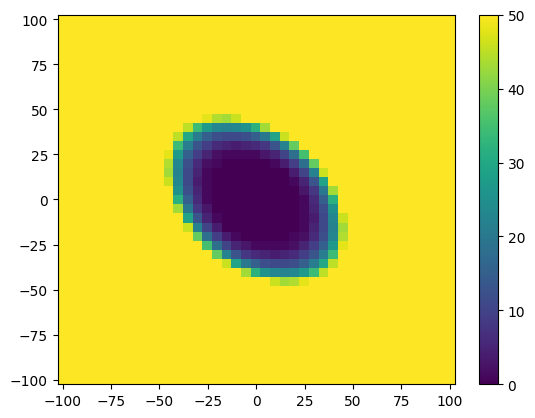

In [134]:
plt.pcolor(Xp, Yp, Err_E, vmin=vmin, vmax=vmax)
plt.colorbar()


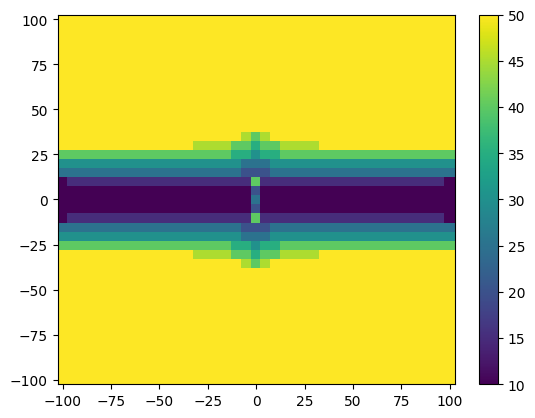

In [135]:
plt.pcolor(Xp, Yp, Search_M)
plt.colorbar()



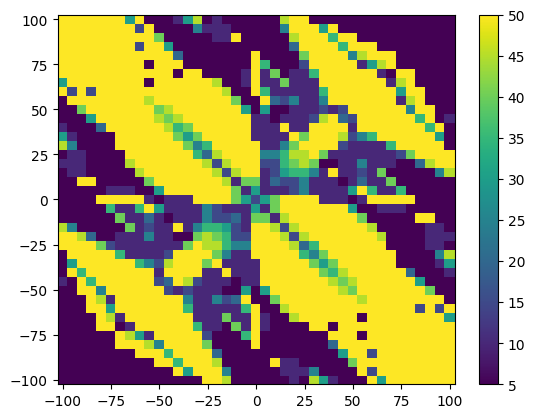

In [136]:
plt.pcolor(Xp, Yp, Search_D)
plt.colorbar()

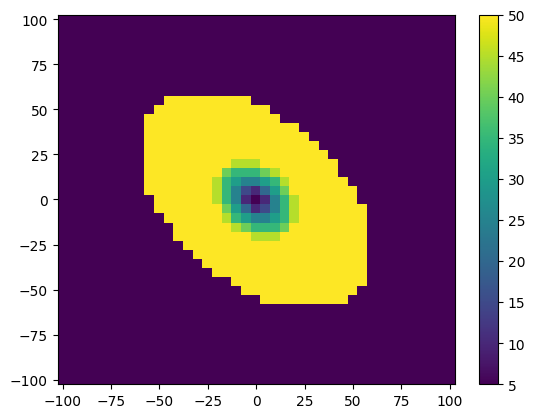

In [137]:
plt.pcolor(Xp, Yp, Search_E)
plt.colorbar()